Creating plot...

Reading data...
Reading data DONE

Calculating T and aerosol tau...
Calculating T and aerosol tau DONE

temp: 819.36 1574.6
max 0.0

Reading data...
Reading data DONE

Calculating T and aerosol tau...
Calculating T and aerosol tau DONE

temp: 828.67 1666.9
max 0.0

Reading data...
Reading data DONE

Calculating T and aerosol tau...
Calculating T and aerosol tau DONE

temp: 686.58 2484.1
max 1.0214356321290759e-05
Creating plot DONE


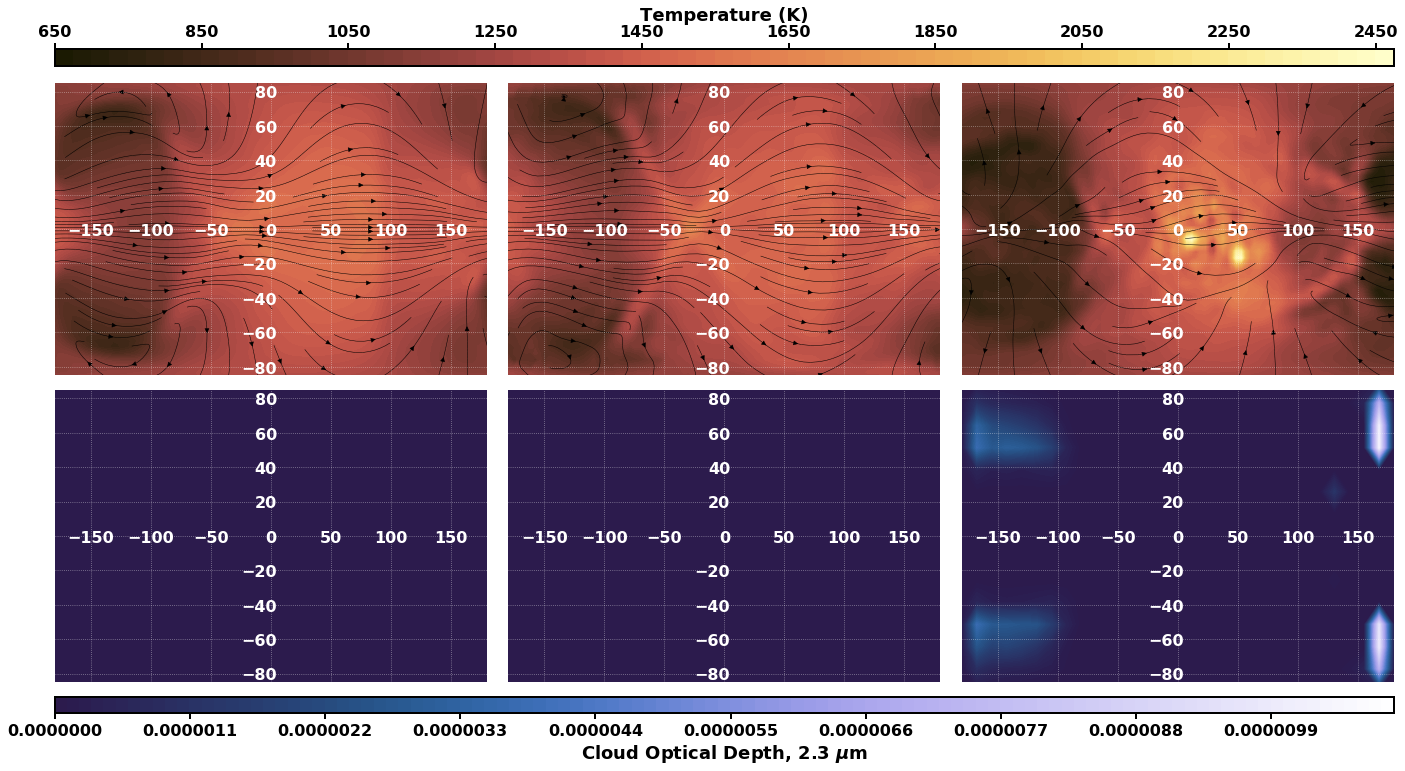

In [74]:
'''


Caleb K. Harada
charada@berkeley.edu



Plots 2d temp and cloud map at some altitude (3 cases)


'''


### ----- INPUT/OUTPUT CONTROL ----- ###

cases = ['LOW-G-CLEAR-250_phase_0.0_inc_0.0',
         'BIG-G-CLEAR-250_phase_0.0_inc_0.0',
         'LOW-G-COM-CLOUDY-250_phase_0.0_inc_0.0']

output_file = 'malsky-testing'


### ----- IMPORT LIBRARIES ----- ###

import numpy as np 
import matplotlib as mpl
from matplotlib import rcParams, rc

import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from scipy.interpolate import interp2d
import matplotlib.colors as colors



# set rcParams ~~~~~~~~~~~~~~~~~~~~~~~~
rcParams['axes.linewidth'] =    2
rcParams['xtick.major.size'] =  6
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.size'] =  3
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.size'] =  6
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.size'] =  3
rcParams['ytick.minor.width'] = 2
font = {'size' : 16, 'weight' : 'bold'}
rc('font', **font)




### ----- MAKE FIGURE ----- ###

print('Creating plot...')


fontsize = 16

# set a few plotting parameters
mpl.rcParams['contour.negative_linestyle'] = 'solid'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,16))
plt.subplots_adjust(wspace=0.05, hspace=0.05)



P_phots = [79.8, 153, 79.8]     # pressure level to probe [mbar; IR photosphere: 26 mbar]
P_phots = [1, 1, 1]     # pressure level to probe [mbar; IR photosphere: 26 mbar]


# file info
nlat = 48
nlon = 193
nlevel = 250
nparams = 22


temp_low = 650
temp_high = 2500

clouds_low = 0.0
clouds_high = 0.075     # thick
#clouds_high = 0.068     # thin

clouds_list = []


for ind, case in enumerate(cases):
    P_phot = P_phots[ind]

    ### ----- LOAD DATA FROM FILE ----- ###

    cloudreport = f'/home/imalsky/Desktop/Final_UPS-{case}.txt'

    print()
    print('Reading data...')
    data = np.loadtxt(cloudreport)
    data = data.reshape((nlat, nlon, nlevel, nparams))
    print('Reading data DONE\n')

    # need to get indices for given pressure level
    pressure_ind = np.zeros((nlat, nlon))

    for i in range(nlat):
        for j in range(nlon):

            k = nlevel - 1

            while data[i][j][k][4] * 1e-2 > P_phot:
                k -= 1

            pressure_ind[i][j] = k


    lons = data[:,:,0,1][0] - 360
    lats = data[:,:,0,0][:,0]


    ### ----- GET LOCAL TEMP, AEROSOL TAU, etc... ----- ###

    print('Calculating T and aerosol tau...')

    temps = np.zeros((nlat, nlon))
    taus = np.zeros((nlat, nlon))
    EW_vels = np.zeros((nlat, nlon))
    NS_vels = np.zeros((nlat, nlon))
    vert_vels = np.zeros((nlat, nlon))
    pressures = np.zeros((nlat, nlon))
    z = np.zeros((nlat, nlon))


    for i in range(nlat):
        for j in range(nlon):

            z[i][j] = data[i][j][int(pressure_ind[i][j])][3]
            pressures[i][j] = data[i][j][int(pressure_ind[i][j])][4]
            temps[i][j] = data[i][j][int(pressure_ind[i][j])][5]
            EW_vels[i][j] = data[i][j][int(pressure_ind[i][j])][6]
            NS_vels[i][j] = data[i][j][int(pressure_ind[i][j])][7]
            vert_vels[i][j] = data[i][j][int(pressure_ind[i][j])][8]




            # integrate aerosol optical depth above pressure level
            k = 0

            while k <= int(pressure_ind[i][j]):

                # conversion to 2.3 microns
                taus[i][j] += data[i][j][k][9] * (0.07 / 0.01) * 0.2 # This 0.2 is because there are 5x more layers
                taus[i][j] += data[i][j][k][12] * (1.25 / 0.16) * 0.2
                taus[i][j] += data[i][j][k][15] * (0.12 / 0.02) * 0.2
                taus[i][j] += data[i][j][k][18] * (0.56 / 0.02) * 0.2

                # The clouds have extremely high optical depths
                k += 1
            



    print('Calculating T and aerosol tau DONE\n')

    lons = data[:,:,0,1][0] - 360
    lats = data[:,:,0,0][:,0]


    ### PLOT STUFF ###



    # temp colormap
    cm_name = 'lajolla'
    cm_file = np.loadtxt(f'/home/imalsky/Desktop/New_Jups/Code/ScientificColourMaps5/{cm_name}/{cm_name}.txt')
    cm_file = np.flip(cm_file, axis=0)
    my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)

    print ('temp:', np.amin(temps), np.amax(temps))
    temp_map = axes[0][ind].contourf(lons, lats, temps, cmap=my_colors, levels=np.arange(temp_low, temp_high, 25))
    temp_map = axes[0][ind].contourf(lons, lats, temps, cmap=my_colors, levels=np.arange(temp_low, temp_high, 25))

    # stream plot
    test_x = np.linspace(min(lons), max(lons), len(lons))
    test_y = np.linspace(min(lats), max(lats), len(lats))

    flow = axes[0][ind].streamplot(test_x, test_y, EW_vels, NS_vels, linewidth=0.5, density=([1, 3]), color='k', zorder=1)

    # cloud colormap
    cm_name = 'devon'
    cm_file = np.loadtxt(f'/home/imalsky/Desktop/New_Jups/Code/ScientificColourMaps5/{cm_name}/{cm_name}.txt')
    my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)




    # interpolate clouds for nicer plotting
    interp_cloud = interp2d(lons, lats, taus, kind='linear')
    lons_new = np.linspace(-180.,180.,30)
    lats_new = np.linspace(-90.,90.,15)
    XX, YY = np.meshgrid(lons_new, lats_new)
    clouds_new = interp_cloud(lons_new, lats_new)

    print ('max', np.amax(clouds_new))
    #cloud_map = axes[1][ind].contourf(XX, YY, np.log10(clouds_new + 0.01), cmap=my_colors, levels=np.arange(-2, 3, 0.1))
    cloud_map = axes[1][ind].contourf(XX, YY, clouds_new, cmap=my_colors, levels=np.arange(0, 0.000011, 0.0000001))

        
# format axes
for ax in axes.flatten():
    ax.set_xlim([-180, 180])
    ax.set_ylim([-85, 85])
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.tick_params(
        axis='both',
        which='both',
        top=False,
        bottom=False,
        right=False,
        left=False,
        labelcolor='w',
        labelsize=fontsize,
        pad=-12
        )
    ax.yaxis.get_major_ticks()[5].label1.set_visible(False)
    ax.grid(color='w', alpha=0.5, ls=':')



temp_cbar = fig.colorbar(temp_map, ax=axes.ravel().tolist(), 
                         norm=colors.LogNorm(vmin=0, vmax=1000),
                         location='top', aspect=80, pad=0.02)

temp_cbar.set_label('Temperature (K)', size=18, weight='bold')

cloud_cbar = fig.colorbar(cloud_map, ax=axes.ravel().tolist(), location='bottom', aspect=80, pad=0.02)
cloud_cbar.set_label('Cloud Optical Depth, 2.3 $\\mu$m', size=18, weight='bold')

print('Creating plot DONE')


fig.savefig(f'/home/imalsky/Desktop/try_again_{output_file}_{P_phot}mbar.png', bbox_inches='tight', dpi=500)
